# Notebook 6
##Prelimenary data visualization with maps for the various environmental data 

In [29]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
import osr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))

import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
from shapely.wkt import loads
import geoplot as gplt

plt.style.use('ggplot') # use ggplot style

## Loading the Shapefiles for the Pacific

In [30]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
drop_cols_shape = ['left', 'top', 'right', 'bottom', 'AREA']
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp').drop(columns = drop_cols_shape)
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp').drop(columns = drop_cols_shape)
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp').drop(columns = drop_cols_shape)

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

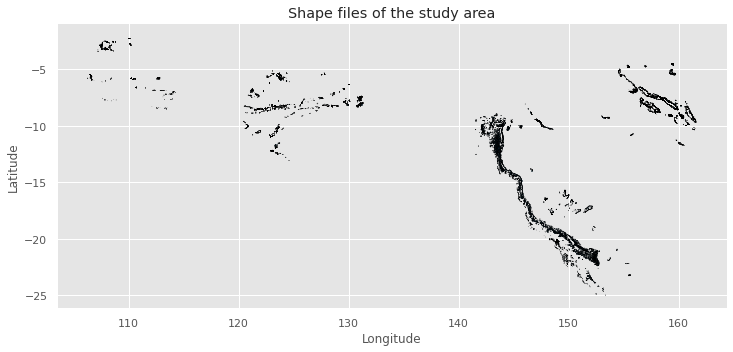

In [31]:
# Plotting the the different shapes

gdf_PAC.plot(edgecolor = "blacK", figsize = (12,7))
plt.title("Shape files of the study area")
plt.xlabel("Longitude")
plt.ylabel("Latitude");

## Loading the Survey folder
It contains the coordinates of the Survey and the percentage of algae, corals, soft_corals or other_invertebrates


In [32]:
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [33]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [34]:
# Change date format 
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')

In [35]:
# Make pacific survey into GeoDataFrame
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lng_start, Survey.lat_start))
gSurvey["country"].value_counts()

AUS    261
IDN    114
TLS     26
SLB     20
Name: country, dtype: int64

We can see that most surveys were taken in Australia followed by Indonesia. With a total of 421 surveys

In [36]:
# Keep only month and year
gSurvey['surveydate'] = gSurvey['surveydate'].dt.strftime('%Y-%m')

#### Degree Heating Week
The DHW shows how much heat stress has accumulated in an area over the past 12 weeks (3 months)

In [37]:
DHW_GBR = pd.read_csv("../Data/Environmental_data/DHW/DHW_GBR.csv")
DHW_IDN = pd.read_csv("../Data/Environmental_data/DHW/DHW_Indonesia.csv")
DHW_SLB = pd.read_csv("../Data/Environmental_data/DHW/DHW_Solomon.csv")
DHW_TLS = pd.read_csv("../Data/Environmental_data/DHW/DHW_Timor.csv")
DHW_GBR.name = "GBR"
DHW_IDN.name = "IDN"
DHW_SLB.name = "SLB"
DHW_TLS.name = "TLS"

In [38]:
# Reorganise data frames
def fix_DHW(df, shapefile):
    if (not isinstance(df["id"][0], np.int64)):
        df["id"] = df["id"].str.replace('R', "").astype(int)
    if (not isinstance(shapefile["id"][0], np.int64)):
        shapefile["id"] = shapefile["id"].str.replace('R', "").astype(int)

    df_temp = df.drop(columns = "id")
    
    df_temp.columns = pd.to_datetime(df_temp.columns)
    df_temp.insert(0, "id", df["id"])
    df = df_temp.copy()
    if("geometry" not in df.columns):
        df = df.merge(shapefile, on = "id")
    return df


In [39]:
DHW_GBR = fix_DHW(DHW_GBR, gdf_AUS)
DHW_IDN = fix_DHW(DHW_IDN, gdf_IND)
DHW_SLB = fix_DHW(DHW_SLB, gdf_SLB)
DHW_TLS = fix_DHW(DHW_TLS, gdf_TLS)
DHW_GBR.name = "GBR"
DHW_IDN.name = "IDN"
DHW_SLB.name = "SLB"
DHW_TLS.name = "TLS"

In [40]:
def plot_DHW_years(df, df1, df2, df3):
    
    fig = df.drop(columns = "id").mean(axis = 0).plot(figsize = (20,7), label = f"DHW_{df.name}")
    df1.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df1.name}")
    df2.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df2.name}")
    df3.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df3.name}")
    plt.title("DHW throughout years")
    plt.ylabel("DHW value")
    plt.xlabel("Date")
    plt.hlines(4, 0,df.shape[0], color = "yellow", label ="Warning")
    plt.legend()
    

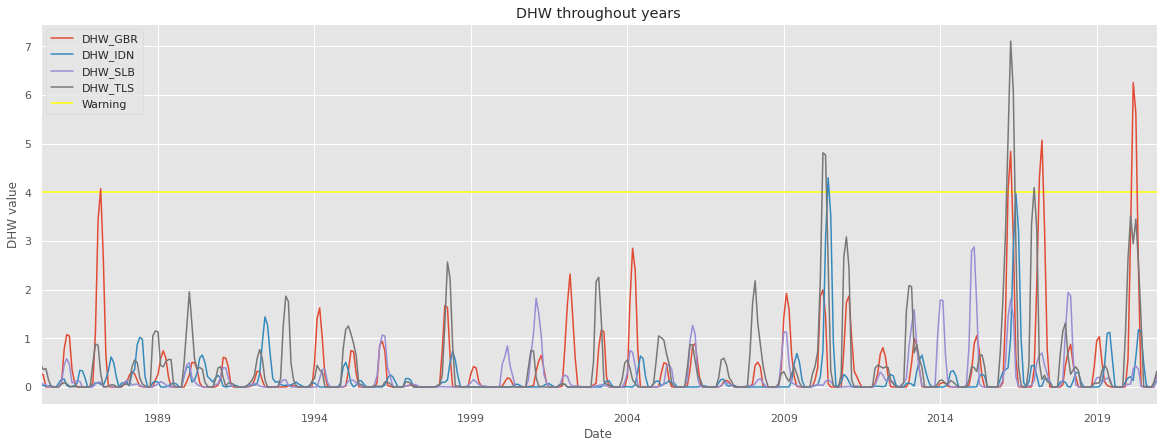

In [41]:
plot_DHW_years(DHW_GBR,DHW_IDN,DHW_SLB,DHW_TLS)

In [42]:
# add a column with number of times DHW has exceedeed "count" 
def add_warning_DHW(df, count):
    if("Exceed_count" not in df.columns):
    
        df["Exceed_count"] = (df.drop(columns = ["id", "geometry"]).iloc[:] > count).sum(axis = 1)
    

In [43]:
# add a column with number of times DHW has exceedeed "count"  count = 4
add_warning_DHW(DHW_GBR, 4)
add_warning_DHW(DHW_IDN, 4)
add_warning_DHW(DHW_SLB, 4)
add_warning_DHW(DHW_TLS, 4)

In [44]:
# Make geodataframe

g_DHW_GBR = pf.make_geo_frame(DHW_GBR)
g_DHW_IDN = pf.make_geo_frame(DHW_IDN)
g_DHW_SLB = pf.make_geo_frame(DHW_SLB)
g_DHW_TLS = pf.make_geo_frame(DHW_TLS)

In [45]:
print("DHW_GBR Exceeds 4 DHW, ",DHW_GBR["Exceed_count"].mean().round(), " times")
print("DHW_IDN Exceeds 4 DHW, ",DHW_IDN["Exceed_count"].mean().round(), " times")
print("DHW_SLB Exceeds 4 DHW, ",DHW_SLB["Exceed_count"].mean().round(), " times")
print("DHW_TLS Exceeds 4 DHW, ",DHW_TLS["Exceed_count"].mean().round(), " times")


DHW_GBR Exceeds 4 DHW,  9.0  times
DHW_IDN Exceeds 4 DHW,  3.0  times
DHW_SLB Exceeds 4 DHW,  1.0  times
DHW_TLS Exceeds 4 DHW,  8.0  times


<AxesSubplot:>

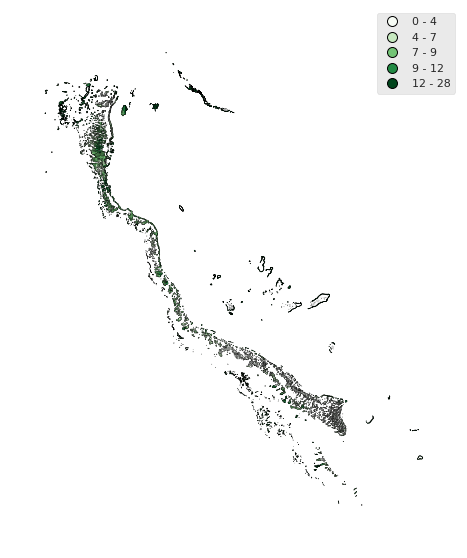

In [46]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import mapclassify as mc
ax = gplt.polyplot(g_DHW_GBR, figsize = (20,10))
scheme = mc.Quantiles(g_DHW_GBR["Exceed_count"], k=5)
gplt.choropleth(
    g_DHW_GBR, hue='Exceed_count', edgecolor="black",
  linewidth=0.1, scheme = scheme, ax = ax,
    cmap='Greens', legend=True
)

### Loading the Surface Sea Temperature 

In [47]:
SST_GBR = pd.read_csv("../Data/Environmental_data/SST/SST_GBR.csv")
SST_IDN = pd.read_csv("../Data/Environmental_data/SST/SST_Indonesia.csv")
SST_SLB = pd.read_csv("../Data/Environmental_data/SST/SST_Solomon.csv")
SST_TLS = pd.read_csv("../Data/Environmental_data/SST/SST_Timor.csv")
SST_GBR.name = "GBR"
SST_IDN.name = "IDN"
SST_SLB.name = "SLB"
SST_TLS.name = "TLS"

In [48]:
SST_GBR = fix_DHW(SST_GBR, gdf_AUS)
SST_IDN = fix_DHW(SST_IDN, gdf_IND)
SST_SLB = fix_DHW(SST_SLB, gdf_SLB)
SST_TLS = fix_DHW(SST_TLS, gdf_TLS)
SST_GBR.name = "GBR"
SST_IDN.name = "IDN"
SST_SLB.name = "SLB"
SST_TLS.name = "TLS"

In [49]:
def plot_SST_years(df, df1, df2, df3):
    
    fig = df.drop(columns = "id").mean(axis = 0).plot(figsize = (10,7), label = f"SST_{df.name}", color = "red")
    df1.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df1.name}", color = "blue")
    df2.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df2.name}", color = "purple")
    df3.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df3.name}", color = "grey")
    plt.hlines(df.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "red", linestyles= 'dashed')
    plt.hlines(df1.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "blue", linestyles= 'dashed')
    plt.hlines(df2.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "purple", linestyles= 'dashed')
    plt.hlines(df3.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "grey", linestyles= 'dashed')
    plt.title("SST_ throughout years")
    plt.ylabel("SST_ value")
    plt.xlabel("Date")
    
    plt.legend()
    

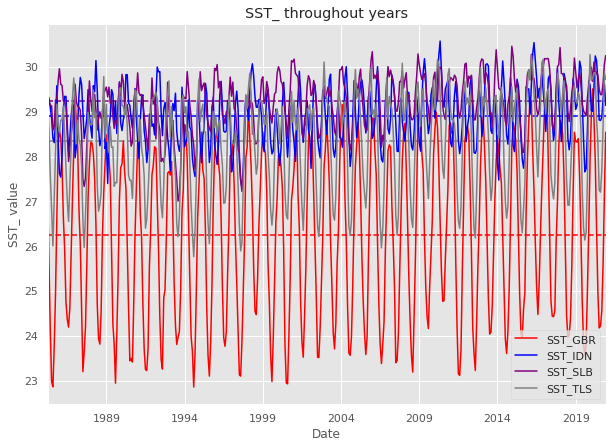

In [50]:
plot_SST_years(SST_GBR,SST_IDN,SST_SLB,SST_TLS)

## Since the rest of the environmental data are real heavy, we will work and analyse the merged dataset

In [51]:
#df_Survey_merged = pd.read_csv("../Data/merged_files_latest.csv")
#df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")
df_Survey_merged = pd.read_csv("../Data/merged_27_04.csv")
df_Survey_merged['surveydate'] = pd.to_datetime(df_Survey_merged['surveydate'], format='%Y-%m')
df_Survey_merged["year"] = df_Survey_merged["surveydate"].dt.year
df_Survey_merged['surveydate'] = df_Survey_merged['surveydate'].dt.strftime('%Y-%m')

In [52]:
df_Survey_merged

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,dist_marine_protection,Population,Population_growth,agr_type,Broad_type,dist_agr,x,y,fish_hours_2012,fish_hours_2014
0,-18.833291,147.651632,11002,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,...,70755.568101,22733465,1.745820,sugar cane,Other crops,74877.709981,1.432945e+06,-2.242241e+06,0.0,843.0383
1,-18.806353,147.669078,11001,2012-10,0.1141,0.6164,0.0497,0.0024,0.2173,AUS,...,74241.879981,22733465,1.745820,sugar cane,Other crops,78264.493182,1.435092e+06,-2.239482e+06,0.0,796.3330
2,-18.665839,147.722256,11004,2012-10,0.0331,0.8568,0.0230,0.0068,0.0805,AUS,...,84840.553472,22733465,1.745820,sugar cane,Other crops,94839.445880,1.442345e+06,-2.224659e+06,0.0,509.6383
3,-18.656207,147.724072,11003,2012-10,0.0485,0.9070,0.0225,0.0098,0.0121,AUS,...,84525.168032,22733465,1.745820,sugar cane,Other crops,95919.730190,1.442651e+06,-2.223622e+06,0.0,482.9302
4,-18.590921,147.565032,11005,2012-10,0.4016,0.4756,0.0185,0.0046,0.0998,AUS,...,89323.079270,22733465,1.745820,sugar cane,Other crops,99649.232437,1.426776e+06,-2.214634e+06,0.0,743.3250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-8.221244,125.530967,30018,2014-07,0.1706,0.6726,0.0805,0.0244,0.0520,TLS,...,164827.725038,1174331,1.807556,NaN,NaN,NaN,-9.703892e+05,-1.003697e+06,0.0,0.0000
412,-8.211822,125.622274,30014,2014-07,0.1706,0.5924,0.1170,0.0689,0.0510,TLS,...,174882.569933,1174331,1.807556,NaN,NaN,NaN,-9.600149e+05,-1.001913e+06,0.0,0.0000
413,-8.183781,125.638740,30013,2014-07,0.1273,0.7098,0.0633,0.0483,0.0513,TLS,...,176750.240429,1174331,1.807556,NaN,NaN,NaN,-9.583455e+05,-9.985668e+05,0.0,0.0000
414,-8.538504,125.606825,30026,2014-08,0.1017,0.5661,0.2066,0.0140,0.1117,TLS,...,176625.962265,1174331,1.807556,NaN,NaN,NaN,-9.592754e+05,-1.039517e+06,0.0,0.0000


In [53]:
# Make geodataframe
df_Survey_merged['geometry'] = df_Survey_merged['geometry'].apply(loads)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)

In [54]:
dp.swap_coordinates(df_Survey_merged)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,dist_marine_protection,Population,Population_growth,agr_type,Broad_type,dist_agr,x,y,fish_hours_2012,fish_hours_2014
0,-18.833291,147.651632,11002,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,...,70755.568101,22733465,1.745820,sugar cane,Other crops,74877.709981,1.432945e+06,-2.242241e+06,0.0,843.0383
1,-18.806353,147.669078,11001,2012-10,0.1141,0.6164,0.0497,0.0024,0.2173,AUS,...,74241.879981,22733465,1.745820,sugar cane,Other crops,78264.493182,1.435092e+06,-2.239482e+06,0.0,796.3330
2,-18.665839,147.722256,11004,2012-10,0.0331,0.8568,0.0230,0.0068,0.0805,AUS,...,84840.553472,22733465,1.745820,sugar cane,Other crops,94839.445880,1.442345e+06,-2.224659e+06,0.0,509.6383
3,-18.656207,147.724072,11003,2012-10,0.0485,0.9070,0.0225,0.0098,0.0121,AUS,...,84525.168032,22733465,1.745820,sugar cane,Other crops,95919.730190,1.442651e+06,-2.223622e+06,0.0,482.9302
4,-18.590921,147.565032,11005,2012-10,0.4016,0.4756,0.0185,0.0046,0.0998,AUS,...,89323.079270,22733465,1.745820,sugar cane,Other crops,99649.232437,1.426776e+06,-2.214634e+06,0.0,743.3250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-8.221244,125.530967,30018,2014-07,0.1706,0.6726,0.0805,0.0244,0.0520,TLS,...,164827.725038,1174331,1.807556,NaN,NaN,NaN,-9.703892e+05,-1.003697e+06,0.0,0.0000
412,-8.211822,125.622274,30014,2014-07,0.1706,0.5924,0.1170,0.0689,0.0510,TLS,...,174882.569933,1174331,1.807556,NaN,NaN,NaN,-9.600149e+05,-1.001913e+06,0.0,0.0000
413,-8.183781,125.638740,30013,2014-07,0.1273,0.7098,0.0633,0.0483,0.0513,TLS,...,176750.240429,1174331,1.807556,NaN,NaN,NaN,-9.583455e+05,-9.985668e+05,0.0,0.0000
414,-8.538504,125.606825,30026,2014-08,0.1017,0.5661,0.2066,0.0140,0.1117,TLS,...,176625.962265,1174331,1.807556,NaN,NaN,NaN,-9.592754e+05,-1.039517e+06,0.0,0.0000


### Simple points of surveys

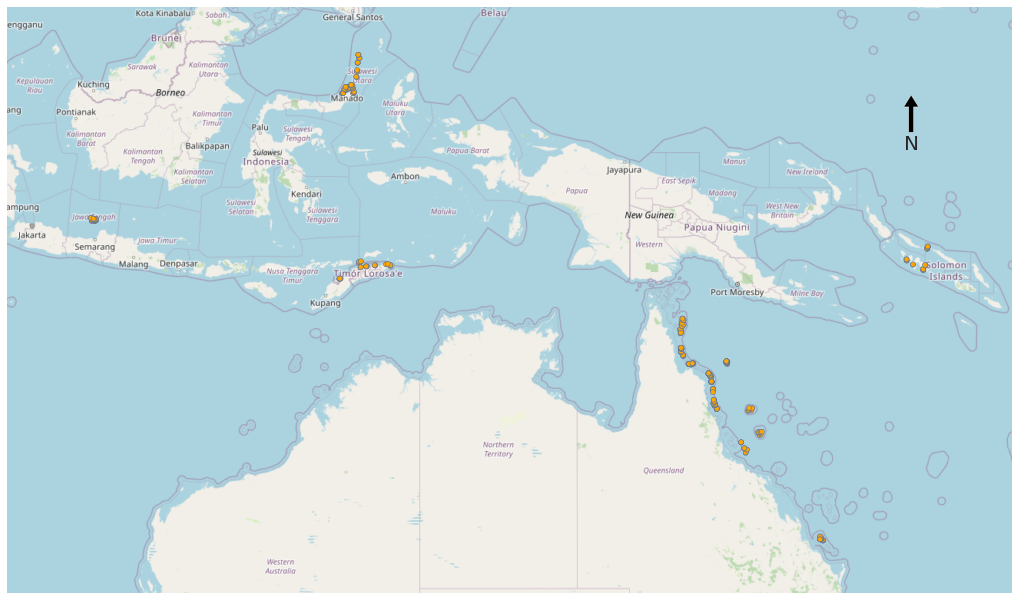

In [73]:
ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(df_Survey_merged, ax =ax, color = "orange",edgecolors='b')
x, y, arrow_length = 0.9, 0.85, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='bottom', fontsize=20,
            xycoords=ax.transAxes)
#plt.title("Survey points", fontsize = 15)
plt.savefig("../Figures report/geo.jpg")


## Distribution of hard corals

Text(0.5, 1.0, 'Survey points and their percentage of hard corals')

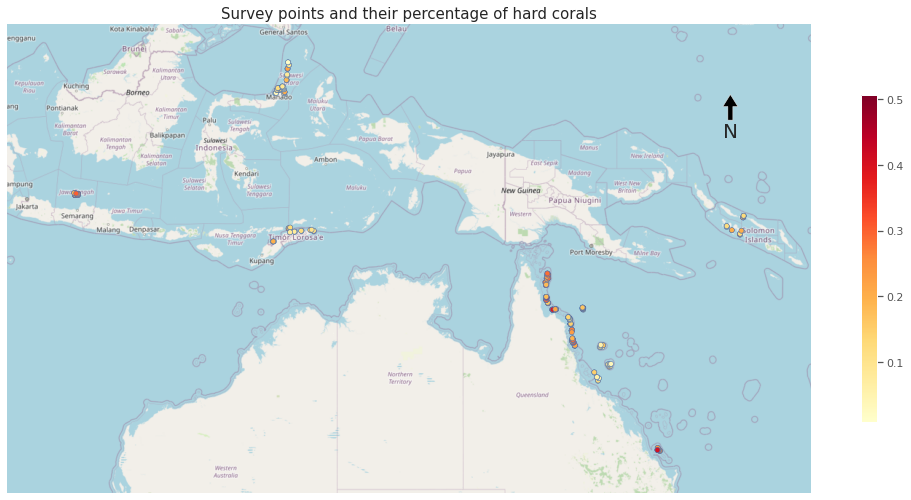

In [56]:
ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", edgecolor = "b",
    hue='pr_hard_coral', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.5}
);
x, y, arrow_length = 0.9, 0.85, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='bottom', fontsize=20,
            xycoords=ax.transAxes)
plt.title("Survey points and their percentage of hard corals", fontsize = 15)

### SST


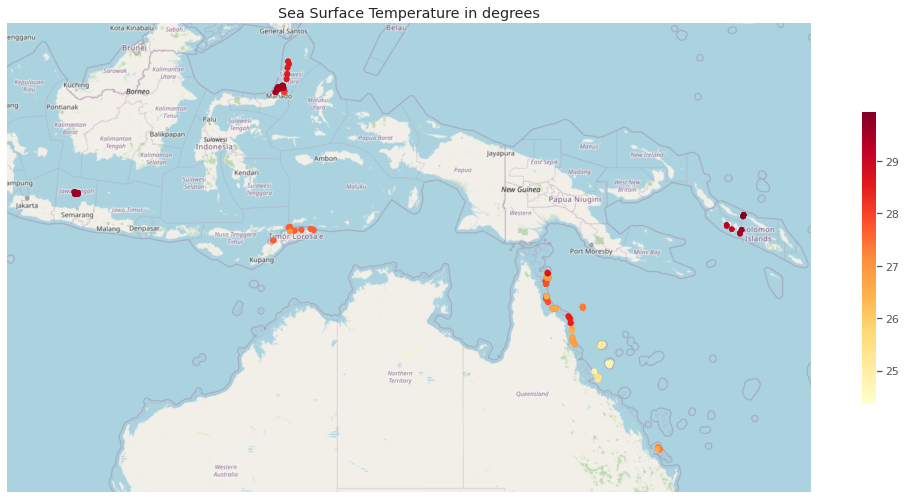

In [57]:

ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd",
    hue='SST', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Sea Surface Temperature in degrees");

### Degree Heating Week 

Text(0.5, 1.0, 'Degree Heating Week')

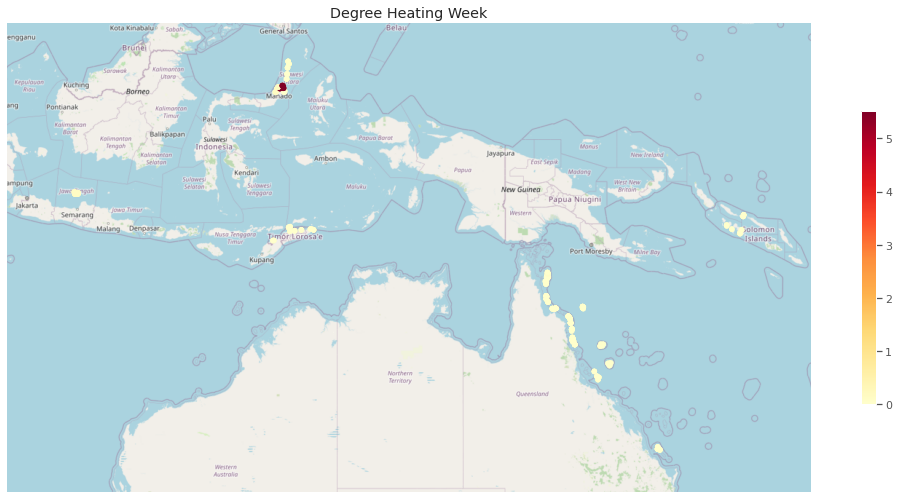

In [49]:

ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='DHW', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Degree Heating Week")

### Wind 

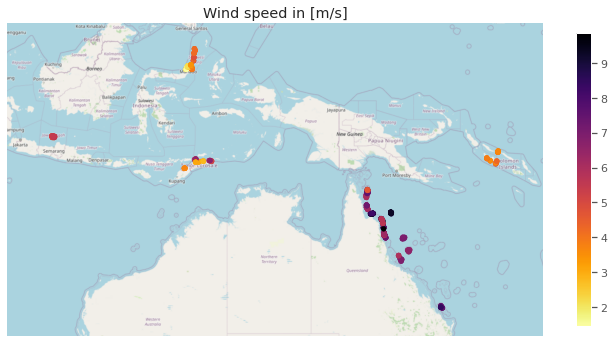

In [50]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "inferno_r",
    hue='wind_speed',
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Wind speed in [m/s]");

### Chlorophyll
To heavy to work with on the big scale, I thus analyse only the merged dataframe

Text(0.5, 1.0, 'Chlorophyll in [mg/m³]')

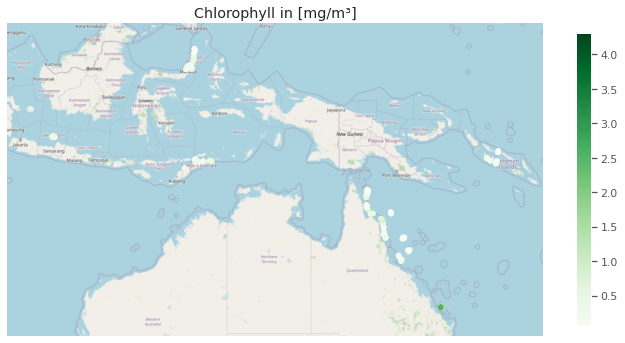

In [51]:
import matplotlib.colors as colors
ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "Greens",
    hue='Chlor', 
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45} 
);
plt.title("Chlorophyll in [mg/m³]")

### Elevation

Text(0.5, 1.0, 'Elevation in meters with sea level reference')

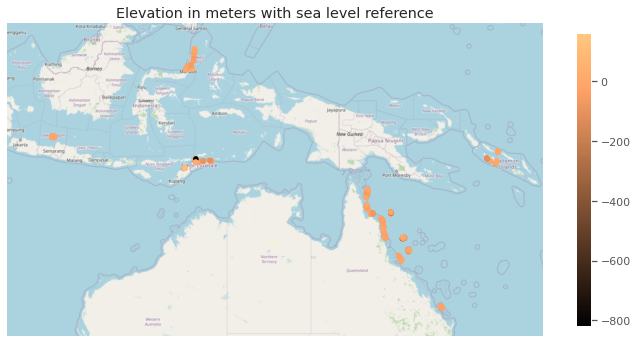

In [52]:
ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "copper",
    hue='elevation',
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45} 
);
plt.title("Elevation in meters with sea level reference")

### Solar radiation

Text(0.5, 1.0, 'Solar radiation in [J m**-2]')

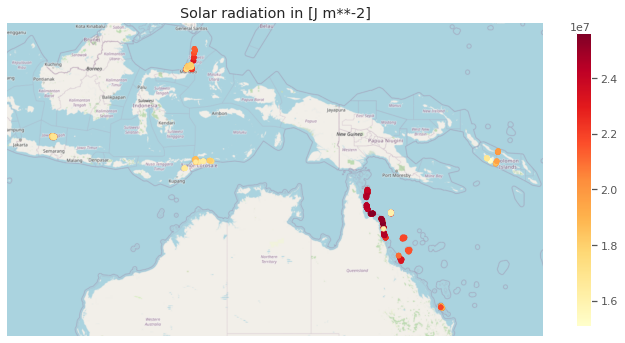

In [53]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='solar_rad', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Solar radiation in [J m**-2]")

### Solar radiation in Clear Sky

In [ ]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='solar_rad_clear_sky', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Solar radiation in clear sky [J m**-2]")

### Closest port

In [ ]:


ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "copper_r", 
    hue='closest_port', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Distance to closest port in [meters]")

In [ ]:
df["surveydate"].value_counts()

### Updated data viz version

In [ ]:
df_IND_diff = pd.read_csv("../Data/Intermediate_csv/diff_IND.csv")
df_AUS_diff = pd.read_csv("../Data/Intermediate_csv/diff_AUS.csv")

In [ ]:
from shapely.wkt import loads
from shapely import wkt
df_IND_diff['geometry'] = df_IND_diff['geometry'].apply(wkt.loads)
df_AUS_diff['geometry'] = df_AUS_diff['geometry'].apply(wkt.loads)
#geo_loads(df_IND_diff)
df_IND_diff = pf.make_geo_frame(df_IND_diff)
df_AUS_diff = pf.make_geo_frame(df_AUS_diff)

In [ ]:
df_AUS_diff.drop(columns =['pr_hard_coral', 'pr_soft_coral', 'pr_algae', 'pr_oth_invert',
       'pr_other', 'others'], inplace = True)
df_IND_diff.drop(columns =['transectid', 'pr_hard_coral', 'pr_soft_coral', 'pr_algae',
       'pr_oth_invert', 'pr_other',  'others'], inplace = True)

In [ ]:
df_diff = pd.concat([df_IND_diff, df_AUS_diff])

In [ ]:
df_Survey_merged_diff = pd.merge(df_Survey_merged,df_diff, on = ["geometry", "year"], how = "outer")
df = df_Survey_merged_diff.copy()

### Distribution plots for numerical values depending on country

In [ ]:
numeric_features= df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_Survey_merged_diff["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Country")

**Interpretation**

Main take-aways: 
- Hard corals have a mean of below 20 % for all countries
- Algea has a broad distribution. highest values for Indonesia, lowest for Timor-Leste
- Wind speed is highest for Australia 
- No specific note for Chlorophyll
- Solar radiation is highest in Australia
- Elevation is similar to all ...
- Australia has lowest SST (link with wind_speed?) but spread out, due to shape or years ? Solomon highest 
- PAR has season variability (paper [https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-0851-3_451]), but highest in TLS (careful with Survey month)
- Closest ports are whithin the same distance for all survey points. Outliers might tell us more of a possible link
- Timor Leste, has the closest Urban places and Australia is quite spread out. This might be interesting because we saw a gradient of hard coral difference between the North and the South during first target variable presentation
- Australia, Solomon and Indesia are close to marine protected areas whereas Timor Leste isn't. Looking at the hard coral distribution, we note that it tends to hold the lowest proportion
- Pity for agriculture that we only have data for Australia which explains the distance 
- We see a positive difference (a.k.a increase) for hard corals in Indonesia, whereas we see a decrease for Australia. The opposite trend can be observed for algae

In [ ]:
plt.figure(figsize = (15, 5))
sns.scatterplot(data = df_Survey_merged_diff ,y = "Population", x = "country", hue = "year")

plt.title("Population")


**Interpretation**

Main take-aways: 
- The population is greatets by far in Indonesia, its population has inctreased

In [ ]:
plt.figure(figsize = (15, 5))
sns.scatterplot(data = df_Survey_merged_diff ,y = "Population_growth", x = "country", hue = "year")
plt.title("Population Growth")

**Interpretation**

Main take-aways:

- Population growth is decreasing for the Indonesia and Australia. We don't have the values for TLS and SLB. but their growth is higher.

### Distribution plots for numerical values depending on year

In [ ]:
df.columns

In [ ]:
numeric_features= df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Year")

**Interpretation**

Main take-aways: 

- I would not make any intersting assumptions since some countries only have values for one year,  they are the only represented. It would be better for the years to look at countries such as Australia and Indonesia 


### Australia

In [ ]:
numeric_features= df[df["country"] == "AUS"].drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff[df_Survey_merged_diff["country"] == "AUS"]["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features for Australia by Year")

**Interpretation**

Main take-aways: 

- Hard Corals degraded with time, opposite for algae
- Wind speed has mostly the same distribution
- PAR seems to have increased with time 
- SST and other variable are constant


### Indonesia

In [ ]:
numeric_features= df[df["country"] == "IDN"].drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff[df_Survey_merged_diff["country"] == "IDN"]["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features for Indonesia by Year")

**Interpretation**

Main take-aways:

- Hard Corals slight increase with time, slight decrease in algae
- Difference in solar radiation but careful (in 2014: october and september survey, in 2018: may and june). So higher in their summer. makes sense ....
- temperature is higher in 2018 even though it is not the summer.


### Correlation Matrix

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year']).corr()
 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap")

**Interpretation**

Main take-aways:

- Opposite interaction between algae and hard corals
- hard corals and urban distance, small correlation. Larger distance, larger hard coral.
- More wind, less SST (- 0.66)
- More wind with greater distance to urban place (0.44)
- More SST, less PAR (-0.51) ?? 
- More SST, more population...
- Greater distance to agriculture, greater SST (no careful, this is because agriculture is in Australia, cooler place thus this correlation appears but wrong... )
- The more the population, the less the population growth 
- 
